# 0) Setup & Reproducibility

In [ ]:
# imports

import os, sys, random, time
import numpy as np
import torch, torchvision
import platform

import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [ ]:
def setup():
    # Global seed
    SEED = 1337

    # Fix seeds
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Environment summary
    print("Environment summary:")
    print(f"  Python: {platform.python_version()}")
    print(f"  torch: {torch.__version__}")
    print(f"  torchvision: {torchvision.__version__}")
    print(f"  Device available: {'cuda' if torch.cuda.is_available() else 'cpu'}")

    # Reproducibility confirmation
    print(f"\nSeed: {SEED} | cudnn.deterministic={torch.backends.cudnn.deterministic} | cudnn.benchmark={torch.backends.cudnn.benchmark}")

Environment summary:
  Python: 3.12.11
  torch: 2.8.0+cu126
  torchvision: 0.23.0+cu126
  Device available: cuda

Seed: 1337 | cudnn.deterministic=True | cudnn.benchmark=False


## 1) Model Architecture

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

def init_model(
    model_name="resnet18",
    pretrained=True,
    alt_act=nn.SiLU,
    keep_first_n_relu=6,
    n_classes=3,
    verbose=True,
):
    """
    Initialize a modified ResNet model:
      1. Load chosen ResNet (18/34/50) with optional pretrained weights.
      2. Replace ReLU activations after the first N with alt_act.
      3. Replace classification head to output n_classes.
    """
    
    # ---- Load model ----
    def load_resnet(name, pretrained=True):
        name = name.lower()
        if name == "resnet18":
            try:
                weights = models.ResNet18_Weights.DEFAULT if pretrained else None
                return models.resnet18(weights=weights)
            except Exception:
                return models.resnet18(pretrained=pretrained)
        elif name == "resnet34":
            try:
                weights = models.ResNet34_Weights.DEFAULT if pretrained else None
                return models.resnet34(weights=weights)
            except Exception:
                return models.resnet34(pretrained=pretrained)
        elif name == "resnet50":
            try:
                weights = models.ResNet50_Weights.DEFAULT if pretrained else None
                return models.resnet50(weights=weights)
            except Exception:
                return models.resnet50(pretrained=pretrained)
        else:
            raise ValueError("model_name must be one of: resnet18, resnet34, resnet50")

    model = load_resnet(model_name, pretrained=pretrained)
    if verbose:
        print(f"Using {model_name}, pretrained={pretrained}")

    # ---- Count parameters ----
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    if verbose:
        print(f"Total params: {total_params:,}")
        print(f"Trainable params: {trainable_params:,}")

    # ---- Collect all ReLUs ----
    relu_locations = []
    def collect_relu(parent, prefix=""):
        for name, child in parent.named_children():
            full = f"{prefix}.{name}" if prefix else name
            if isinstance(child, nn.ReLU):
                relu_locations.append((parent, name, full))
            collect_relu(child, full)
    collect_relu(model)
    total_relu_before = len(relu_locations)
    if verbose:
        print(f"\nTotal nn.ReLU before replacement: {total_relu_before}")

    # ---- Replace ReLU after keep_first_n_relu ----
    replaced_indices_0based = []
    for idx, (parent, child_name, full) in enumerate(relu_locations):
        if idx >= keep_first_n_relu:
            setattr(parent, child_name, alt_act())
            replaced_indices_0based.append(idx)

    # ---- Sanity check ----
    count_relu_after, count_alt_after = 0, 0
    def count_acts(mod):
        nonlocal count_relu_after, count_alt_after
        for child in mod.children():
            if isinstance(child, nn.ReLU):
                count_relu_after += 1
            if isinstance(child, alt_act):
                count_alt_after += 1
            count_acts(child)
    count_acts(model)

    intended_replacements = max(0, total_relu_before - keep_first_n_relu)
    assert count_relu_after + count_alt_after == total_relu_before, \
        "Mismatch after replacement!"
    assert count_alt_after == intended_replacements, \
        f"Expected {intended_replacements}, got {count_alt_after}"

    if verbose:
        replaced_indices_1based = [i+1 for i in replaced_indices_0based]
        print(f"Replacing activations at indices (1-based): {replaced_indices_1based} with {alt_act.__name__}")
        print(f"ReLU remaining: {count_relu_after}")
        print(f"{alt_act.__name__} inserted: {count_alt_after}")
        print("Assertion passed: replacements successful.")

    # ---- Replace head ----
    old_in, old_out = model.fc.in_features, model.fc.out_features
    model.fc = nn.Linear(old_in, n_classes)
    if verbose:
        print(f"\nOld head: in_features={old_in} -> out_features={old_out}")
        print(f"New head: in_features={old_in} -> out_features={n_classes}")
        print(f"Number of target classes: {n_classes}")

    return model

Using resnet18, pretrained=True
Total params: 11,689,512
Trainable params: 11,689,512

Total nn.ReLU before replacement: 9
Replacing activations at indices (1-based): [7, 8, 9] with SiLU
(Using 1-based indexing in the above list; kept first 6 ReLU modules)
ReLU remaining: 6
SiLU inserted: 3
Assertion passed: exactly the intended number were replaced.

Old head: in_features=512 -> out_features=1000
New head: in_features=512 -> out_features=3
Number of target classes: 3


# Data

CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Selected classes: ['airplane', 'cat', 'dog']
Original IDs: [0, 3, 5]
Mapping (old_id → new_id): {0: 0, 3: 1, 5: 2}
Mapping (name → new_id): {'airplane': 0, 'cat': 1, 'dog': 2}

Class counts:
Train: {0: 4515, 1: 4473, 2: 4512}
Val:   {0: 485, 1: 527, 2: 488}
Test:  {0: 1000, 1: 1000, 2: 1000}

Transform summary:
Train: Compose(
    ToPILImage()
    RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)
Val: Compose(
    ToPILImage()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)

Train batch shape: torch.Size([64, 3, 32, 32]), labels: torch.Size([64])
Val batch shape: torch.Size

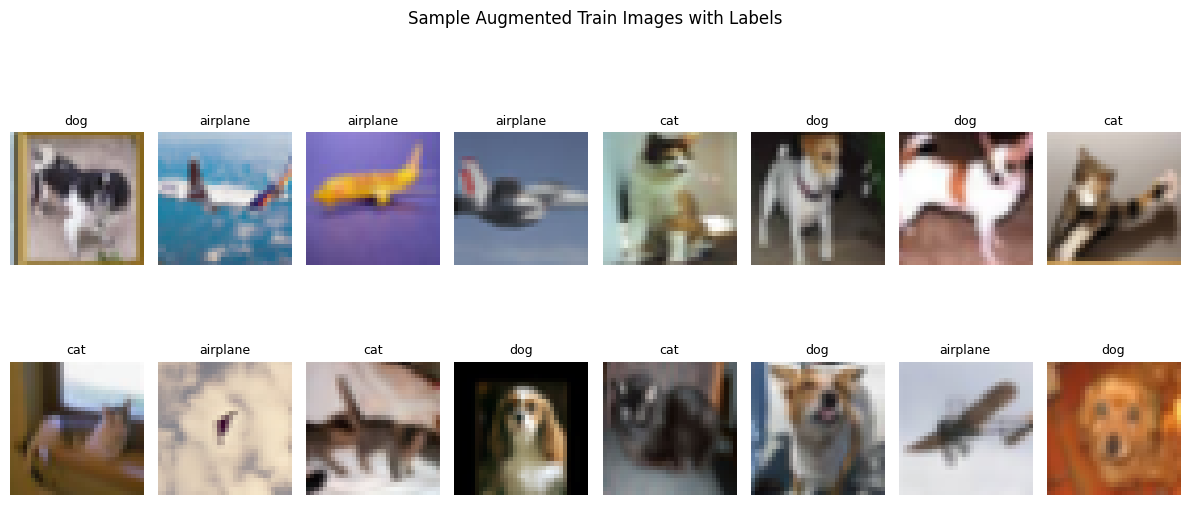

In [ ]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def prepare_data_pipeline(
    selected_classes=["airplane", "cat", "dog"],
    batch_size=64,
    val_split=0.1,
    root="./data",
    show_example=True
):
    """
    Prepare CIFAR-10 pipeline:
      - Filter to selected_classes
      - Relabel to contiguous IDs
      - Train/Val split
      - Apply augmentations
      - Return train/val/test DataLoaders and metadata
    """
    # ---- Load CIFAR-10 ----
    train_full = torchvision.datasets.CIFAR10(root=root, train=True, download=True)
    test_full = torchvision.datasets.CIFAR10(root=root, train=False, download=True)
    cifar_classes = train_full.classes

    # ---- Class filtering ----
    selected_ids = [cifar_classes.index(c) for c in selected_classes]
    id2new = {old: new for new, old in enumerate(selected_ids)}
    name2new = {cifar_classes[old]: new for old, new in id2new.items()}

    print("Selected classes:", selected_classes)
    print("Mapping (old_id → new_id):", id2new)
    print("Mapping (name → new_id):", name2new)

    def filter_dataset(dataset, selected_ids, id2new):
        imgs, labels = [], []
        for x, y in zip(dataset.data, dataset.targets):
            if y in selected_ids:
                imgs.append(x)
                labels.append(id2new[y])
        return np.array(imgs), np.array(labels)

    train_imgs, train_labels = filter_dataset(train_full, selected_ids, id2new)
    test_imgs, test_labels = filter_dataset(test_full, selected_ids, id2new)

    # ---- Train/Val split ----
    n_total = len(train_labels)
    n_val = int(n_total * val_split)
    n_train = n_total - n_val
    indices = np.random.permutation(n_total)
    train_idx, val_idx = indices[:n_train], indices[n_train:]
    train_imgs_split, val_imgs_split = train_imgs[train_idx], train_imgs[val_idx]
    train_labels_split, val_labels_split = train_labels[train_idx], train_labels[val_idx]

    def count_labels(labels):
        c = Counter(labels)
        return {cls: c[cls] for cls in range(len(selected_classes))}

    print("\nClass counts:")
    print("Train:", count_labels(train_labels_split))
    print("Val:  ", count_labels(val_labels_split))
    print("Test: ", count_labels(test_labels))

    # ---- Transforms ----
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
    print("\nTransform summary:")
    print("Train:", train_transform)
    print("Val:", val_transform)

    # ---- Custom dataset wrapper ----
    class CustomCIFAR(torch.utils.data.Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = images
            self.labels = labels
            self.transform = transform
        def __len__(self):
            return len(self.labels)
        def __getitem__(self, idx):
            x, y = self.images[idx], self.labels[idx]
            if self.transform:
                x = self.transform(x)
            return x, y

    train_ds = CustomCIFAR(train_imgs_split, train_labels_split, transform=train_transform)
    val_ds   = CustomCIFAR(val_imgs_split, val_labels_split, transform=val_transform)
    test_ds  = CustomCIFAR(test_imgs, test_labels, transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # ---- Optional visualization ----
    def show_batch(x, y):
        x = x[:16].cpu()
        y = y[:16].cpu()
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        x = x * std + mean
        plt.figure(figsize=(12, 6))
        for i in range(len(x)):
            img = x[i].numpy().transpose((1, 2, 0))
            label_id = y[i].item()
            label_name = [k for k, v in name2new.items() if v == label_id][0]
            plt.subplot(2, 8, i + 1)
            plt.imshow(np.clip(img, 0, 1))
            plt.axis("off")
            plt.title(label_name, fontsize=9)
        plt.suptitle("Sample Augmented Train Images with Labels", fontsize=12)
        plt.tight_layout()
        plt.show()

    if show_example:
        xb, yb = next(iter(train_loader))
        print(f"\nTrain batch shape: {xb.shape}, labels: {yb.shape}")
        show_batch(xb, yb)

    return train_loader, val_loader, test_loader, name2new

In [4]:
## 3) Training & Evaluation

Epoch 1/5 | Train Loss: 0.503 | Train Acc: 78.5% | Val Loss: 0.421 | Val Acc: 82.1%
Epoch 2/5 | Train Loss: 0.390 | Train Acc: 83.0% | Val Loss: 0.409 | Val Acc: 82.7%
Epoch 3/5 | Train Loss: 0.353 | Train Acc: 85.2% | Val Loss: 0.414 | Val Acc: 83.1%
Epoch 4/5 | Train Loss: 0.335 | Train Acc: 85.5% | Val Loss: 0.428 | Val Acc: 83.5%
Epoch 5/5 | Train Loss: 0.304 | Train Acc: 87.2% | Val Loss: 0.428 | Val Acc: 83.3%

Best Val Acc: 83.47% (epoch 4)

Final Val Acc: 83.27%


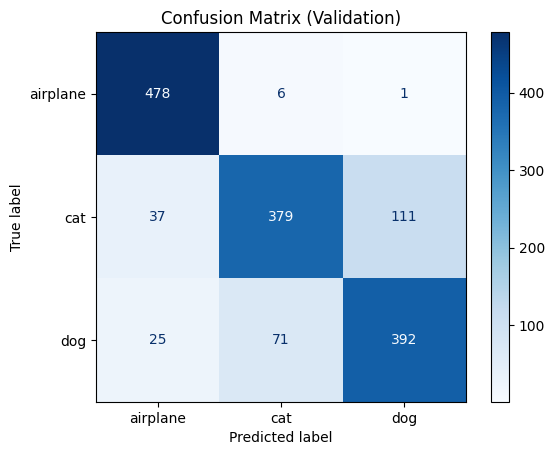


Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.99      0.93       485
         cat       0.83      0.72      0.77       527
         dog       0.78      0.80      0.79       488

    accuracy                           0.83      1500
   macro avg       0.83      0.84      0.83      1500
weighted avg       0.83      0.83      0.83      1500



In [ ]:
def train_and_evaluate(
    model,
    train_loader,
    val_loader,
    device,
    epochs=5,
    lr=1e-3,
    class_names=None
):
    """
    Train and evaluate a PyTorch model with CrossEntropyLoss + Adam + tqdm progress bars.
    """
    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Trackers
    best_val_acc = 0.0
    best_epoch = -1
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    model = model.to(device)

    for epoch in range(1, epochs + 1):
        # ---- Training ----
        model.train()
        train_loss, train_correct, n_train = 0.0, 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            train_correct += (out.argmax(1) == yb).sum().item()
            n_train += xb.size(0)

            pbar.set_postfix(loss=loss.item())

        train_loss /= n_train
        train_acc = train_correct / n_train

        # ---- Validation ----
        model.eval()
        val_loss, val_correct, n_val = 0.0, 0, 0
        all_preds, all_labels = [], []

        pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for xb, yb in pbar:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)

                val_loss += loss.item() * xb.size(0)
                preds = out.argmax(1)
                val_correct += (preds == yb).sum().item()
                n_val += xb.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

                pbar.set_postfix(loss=loss.item())

        val_loss /= n_val
        val_acc = val_correct / n_val

        # Track history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Print epoch summary
        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.1f}% | "
              f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.1f}%")

        # Track best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

    print(f"\nBest Val Acc: {best_val_acc*100:.2f}% (epoch {best_epoch})")
    print(f"Final Val Acc: {history['val_acc'][-1]*100:.2f}%")

    # ---- Reporting ----
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix (Validation)")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return model, history, best_val_acc, best_epoch

In [ ]:
setup()

model = init_model()

train_loader, val_loader, test_loader, class_map = prepare_data_pipeline()

trained_model, history, best_acc, best_epoch = train_and_evaluate(model, train_loader, val_loader, device="cuda")

